In [1]:
#%%
import numpy as np
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
import numba as nb
import sys
import os

sys.path.insert(0, os.path.realpath('./transport/'))

from transport import tallies
from transport import material_definitions
from transport import functions_for_transport
from transport import functions_for_scattering_theory as xs

from transport.functions_for_PTables import get_resonance_ladder
from transport.functions_for_PTables import calculate_xs_history


from scipy.optimize import minimize


In [2]:
%matplotlib widget

### Match Benchmark
Plot and print out values


Incorrect statement:
"Since the value of ν is 0 for the capture isotope, the total fission cross section is given only by the fission isotope."

In [3]:
resonance_ladder_pu9 = pd.DataFrame({'E'    :   [2.956242e-1], #, 2.5e3, 3e3],
                                'Gn'    :   [7.947046e-5], #, 7.947046e-5, 7.947046e-5],
                                'Gg'    :   [3.982423e-2], #, 3.982423e-2, 3.982423e-2],
                                'Gf'    :   [5.619673e-2]}) #, 5.619673e-2, 5.619673e-2]})

pair_constants_pu9 = {
'ac':0,             # 1e-12cm
'p0':0.002196807122623 * 1/2 ,   # 1 / 1e-12cm - sqrt(eV)
'gj':3/4,
}

resonance_ladder_u8 = pd.DataFrame({'E'    :    [6.674280], # 2.5e3, 3e3],
                                    'Gn'    :   [1.492300e-3], # 1.492300e0, 1.492300e0],
                                    'Gg'    :   [2.271100e-2], # 2.271100e0, 2.271100e0],
                                    'Gf'    :   [9.880000e-9]}) # 9.880000e-9, 9.880000e-9]})

pair_constants_u8 = {
'ac':0,   # 1e-12cm
'p0':0.002196807122623 * 1/2 ,   # 1 / 1e-12cm - sqrt(eV)
'gj':1,
}

Npu9 = 1
Nu8 = 0.124954
Nscat = 0.008340505

pu9 = material_definitions.isotope(pair_constants_pu9, resonance_ladder_pu9, Npu9, 2.88)
u8 = material_definitions.isotope(pair_constants_u8, resonance_ladder_u8, Nu8, 0)

mat_no_URR = material_definitions.material([pu9,u8], constant_scattering=20*Nscat)



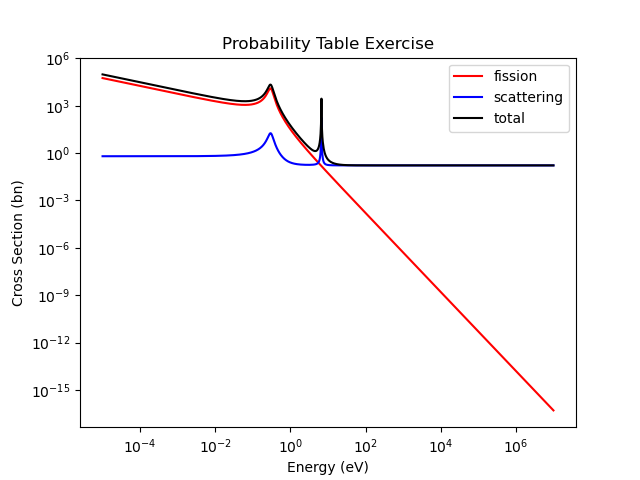

In [4]:

benchmark_e = np.array([0.00001, 0.01000, 0.29562, 6.67425, 100.000, 2.0e7])
# benchmark_e = np.array([2.25e3, 2.5e3, 2.75e3, 3e3, 3.25e3])
# benchmark_e = np.array([6.67425])
energy = np.logspace(-5,7, 1000)
# energy = benchmark_e


pu9_Sig_t, pu9_Sig_g, pu9_Sig_s, pu9_Sig_f = pu9.get_macro_cross_sections(energy)
u8_Sig_t, u8_Sig_g, u8_Sig_s, u8_Sig_f = u8.get_macro_cross_sections(energy)

m_Sig_t, m_Sig_g, m_Sig_s, m_Sig_f = mat_no_URR.get_macro_cross_sections(energy)


if np.array_equal(energy,benchmark_e):
    print(f'energy:\n {energy}')
    print(f'fission:\n {m_Sig_f}')
    print(f'scattering:\n {m_Sig_s}')
    print(f'total:\n {m_Sig_t}')
    # print(f'fission:\n {pu9_Sig_f}')
    # print(f'scattering:\n {pu9_Sig_s}')
    # print(f'total:\n {pu9_Sig_t}')
     
 
 
else:
    figure()
    plot(energy, m_Sig_f, color='r', label='fission')
    # plot(energy, m_Sig_g, label='gamma')
    plot(energy, m_Sig_s, color='b', label='scattering')
    plot(energy, m_Sig_t, color='k', label='total')

    # plot(energy, u8_Sig_t, label='U8 total')
    # plot(energy, u8_Sig_f, label='U8 f')

    xlabel('Energy (eV)'); ylabel('Cross Section (bn)')
    title('Probability Table Exercise')

    xscale('log'); yscale('log')
    legend()

## Sample a URR Ladder
For Pu-239
For U238, the URR occurs from 20 keV to just above 149 keV. 
Let's start simple, get rid of the Pu-239 isotope and do the following:
1. Take a reference point $E_{ref}$ = 100 keV
2. Generate resonance-pair sequences out to either side of $E_{ref}$ and reconstruct the Fission, Capture, and Elastic scattering cross sections. (Make a nice plot!)
3. Use the Dyson-Mehta $\Delta_3$ statistic to terminate the end of the simulated resonance ladder

[5.24217678e-05] [3.70743706e-05] [1.80090574e-06] [1.35464915e-05]
Min/Max of total: 1.7408106983690254e-10/0.8460307755414135


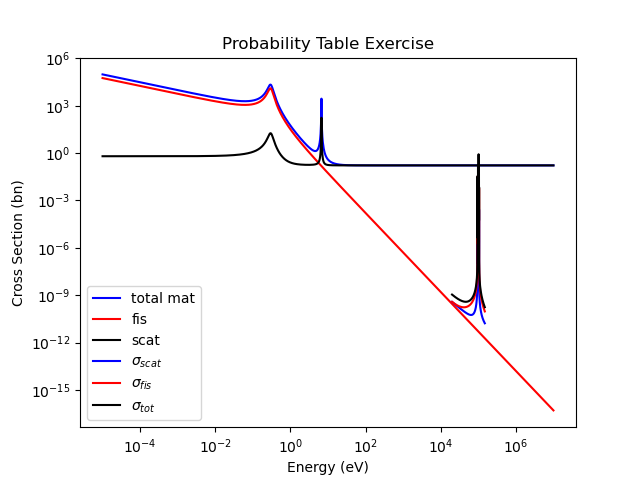

In [5]:
u8_Sig_t, u8_Sig_f, u8_Sig_g, u8_Sig_s = u8.get_macro_cross_sections(energy)

D_avg_u8 = 10
Gn_avg_u8 = 1.492300e-3
Gg_avg_u8 = 2.271100e-2
Gf_avg_u8 = 9.880000e-9
    
D_avg_pu9 = 10
Gn_avg_pu9 = 7.947046e-5
Gg_avg_pu9 = 3.982423e-2
Gf_avg_pu9 = 5.619673e-2


Ebins = np.array([100])*1e3
vEbins = np.array([20,149])*1e3
# for E ref in Ebins if I want to build a ptable for multiple energy bins
E_ref = Ebins[0]
# URR_energy = np.linspace(20e3, 149e3, 10000) # full URR range for U8
URR_energy = np.concatenate( [np.linspace(min(vEbins), E_ref, 5000), np.linspace(E_ref, max(vEbins), 5000)] )


# sample resonance ladder for both isotopes
u8_URR_ladder = get_resonance_ladder(E_ref, 500, D_avg_u8, Gg_avg_u8, Gn_avg_u8, Gf_avg_u8)
pu9_URR_ladder = get_resonance_ladder(E_ref, 500, D_avg_pu9, Gg_avg_pu9, Gn_avg_pu9, Gf_avg_pu9)
u8_URR = material_definitions.isotope(pair_constants_u8, u8_URR_ladder, Nu8, 0)
pu9_URR = material_definitions.isotope(pair_constants_pu9, pu9_URR_ladder, Npu9, 2.88)
if np.any(u8_URR_ladder.E <0):
    raise ValueError("negative resonance sampled")
                     
# add to material, reconstruct CE cross section and save rxns cross sections at Eref
mat_wURR = material_definitions.material([pu9,u8, u8_URR, pu9_URR], constant_scattering=0*Nscat)
rxns_Eref, rxns_CE = calculate_xs_history(URR_energy, E_ref, mat_wURR)
Sig_t_Eref_hist, Sig_g_Eref_hist, Sig_s_Eref_hist, Sig_f_Eref_hist = rxns_Eref
Sig_t_URR, Sig_g_URR, Sig_s_URR, Sig_f_URR = rxns_CE
print(Sig_t_Eref_hist, Sig_g_Eref_hist, Sig_s_Eref_hist, Sig_f_Eref_hist)

# mat_wURR.get_macro_cross_sections



figure()
plot(energy, m_Sig_t, label='total mat', color='b')
plot(energy, m_Sig_f, label='fis', color='r')
# plot(energy, m_Sig_g, label='cap', color='orange')
plot(energy, m_Sig_s, label='scat', color='k')

# plot(URR_energy, Sig_g_URR, color='orange')
plot(URR_energy, Sig_s_URR, color='b', label=r'$\sigma_{scat}$')
plot(URR_energy, Sig_f_URR, color='r', label=r'$\sigma_{fis}$')
plot(URR_energy, Sig_t_URR, color='k', label=r'$\sigma_{tot}$')

xscale('log')
yscale('log')
xlabel('Energy (eV)'); ylabel('Cross Section (bn)')
title('Probability Table Exercise')

legend()
print(f'Min/Max of total: {min(Sig_t_URR)}/{max(Sig_t_URR)}')

## Test transport with URR Resonance

Takes forever because I am calculating the cross section each time (looping over all resonances in the URR). Need to calculate before hand, store, and interpolate.

In [6]:
# # test
N = 1.5e2
G = 200
iE = 200
print(f'Particle Histories: {N}')
print(f'Energy Bins: {iE}')

Emin = 1e-5
Emax = 2e7 
iEbins = 200
tally = tallies.tallies(Emin, Emax, iEbins)

URR_Erange = np.array([20,149])*1e3
URR_single_history_xs = [Sig_t_Eref_hist, Sig_g_Eref_hist, Sig_s_Eref_hist, Sig_f_Eref_hist]
rng = np.random.default_rng()

tally_avg = functions_for_transport.transport_loop_0D_CE(N, G, tally, mat_no_URR, rng, URR_Erange, None, URR_single_history_xs)
final_k_estimate, final_estimator_variance, collision_based_scalar_flux = tally.final_analysis() 

print(final_k_estimate, final_estimator_variance)

Particle Histories: 150.0
Energy Bins: 200
0.24563333333333331 0.004717620249149675


### Now tally the cross section at E_reference

Notes:
- min and max cross section bounds are actually determined after the MC simulation
- the bin structure and tallying is actually done only on the total cross section! i.e. the band selection for the partial reactions is based on the band selection for the total cross section
- For one batch
    - the average cross section in the band is calculated as the sum of all cross section samples that fall within the band divided by the number of tallies that band got
    - the probabilty of the band is calculated as the number of tallies the band got divided by the total number of histories in the batch
- Then, the 'grand mean' is calculated using each of the batches

In [6]:
def setup_reaction_xs_bins(minxs, maxxs, ibins):
    vbins = np.logspace(minxs, maxxs,ibins+1) #edges
    dbins = np.zeros(len(vbins)-1)
    bins = np.zeros(len(vbins)-1) # midpoints
    for i in range(1,len(vbins)):
        dbins[i-1] = vbins[i] - vbins[i-1] 
        bins[i-1] = (vbins[i]+vbins[i-1])/2 
    return bins, vbins

def determine_bindex(sigma, vBins):
    assert len(sigma) == 1
    bindex = np.searchsorted(vBins, sigma)
    return bindex

def tally_rxn(tally, sigma, bindex):
    assert len(sigma) == 1
    tally[0, bindex] += sigma
    tally[1, bindex] += sigma**2
    return tally


TotBins, vTotBins = setup_reaction_xs_bins(-5, -1, 6)
# TotBins, vTotBins = setup_reaction_xs_bins(0.166, 0.175, 6)
print(vTotBins)

# figure()
# for each in vTotBins:
#     axhline(each, color='b')
# yscale('log')


[1.00000000e-05 4.64158883e-05 2.15443469e-04 1.00000000e-03
 4.64158883e-03 2.15443469e-02 1.00000000e-01]


3.209132099966819e-05

### Generate PTable

In [26]:
batches = 2
histories = 100

TotTally = np.zeros((batches,len(TotBins)+2))
CapTally = np.zeros((batches,len(TotBins)+2))
ScatTally = np.zeros((batches,len(TotBins)+2))
FisTally = np.zeros((batches,len(TotBins)+2))
PTally = np.zeros((batches,len(TotBins)+2))
rxn_means = np.zeros((1,4))

save_vals_csv = open('xs_histories.csv', 'a')

for ibatch in range(batches):

    # tally containers for history 
    tally_list = [np.zeros((2,len(TotBins)+2)) for i in range(4)]
    ptally = np.zeros((1,len(TotBins)+2))

    for ihist in range(histories):

        # sample resonance ladder for both isotopes
        u8_URR_ladder = get_resonance_ladder(E_ref, 500, D_avg_u8, Gg_avg_u8, Gn_avg_u8, Gf_avg_u8)
        pu9_URR_ladder = get_resonance_ladder(E_ref, 500, D_avg_pu9, Gg_avg_pu9, Gn_avg_pu9, Gf_avg_pu9)
        u8_URR = material_definitions.isotope(pair_constants_u8, u8_URR_ladder, Nu8, 0)
        pu9_URR = material_definitions.isotope(pair_constants_pu9, pu9_URR_ladder, Npu9, 2.88)
                            
        # add to material, reconstruct CE cross section and save rxns cross sections at Eref
        mat_wURR = material_definitions.material([pu9,u8, u8_URR, pu9_URR], constant_scattering=0*Nscat)
        rxns_Eref, rxns_CE = calculate_xs_history(URR_energy, E_ref, mat_wURR)
        Sig_t_Eref_hist, Sig_g_Eref_hist, Sig_s_Eref_hist, Sig_f_Eref_hist =  [np.nan_to_num(rxn) for rxn in rxns_Eref]

        save_vals_csv.write(f'{Sig_t_Eref_hist.item()}, {Sig_g_Eref_hist.item()}, {Sig_s_Eref_hist.item()}, {Sig_f_Eref_hist.item()}\n')

        # tally mean values
        rxn_means += np.array([Sig_t_Eref_hist, Sig_g_Eref_hist, Sig_s_Eref_hist, Sig_f_Eref_hist]).T

        # tally probability table determined by total xs and reaction xs
        bindex = determine_bindex(Sig_t_Eref_hist, vTotBins)
        sigma_list = [Sig_t_Eref_hist, Sig_g_Eref_hist, Sig_s_Eref_hist, Sig_f_Eref_hist]
        tally_list = [tally_rxn(rxn_tally, rxn_sigma, bindex) for rxn_tally, rxn_sigma in zip(tally_list, sigma_list)]
        ptally[0, bindex] += 1

    # calculate mean and store for batch
    PTally[ibatch, :] = ptally[0, :]/np.sum(ptally)
    # batch_avg_list  = [rxn_tally[0,:]/ptally for rxn_tally in tally_list]
    batch_avg_list = [np.nan_to_num(rxn_tally[0,:]/ptally) for rxn_tally in tally_list]
    # if np.any(np.isnan(batch_avg_list[0])):
    #     batch_avg_list = [np.nan_to_num(rxn_tally[0,:]) for rxn_tally in tally_list]
    TotTally[ibatch, :] = batch_avg_list[0]
    # print(tally_list[0][0,:])
    # print(ptally)
    # print(TotTally)
    CapTally[ibatch, :] = batch_avg_list[1]
    ScatTally[ibatch, :] = batch_avg_list[2]
    FisTally[ibatch, :] = batch_avg_list[3]

save_vals_csv.close()
# total mean cross section at E_ref
rxn_means = rxn_means/(batches*histories)

/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_14262/2059334247.py:46: RuntimeWarning: invalid value encountered in divide
  batch_avg_list = [np.nan_to_num(rxn_tally[0,:]/ptally) for rxn_tally in tally_list]


In [7]:
# np.save('./TotTally.npy', TotTally)
# np.save('./CapTally.npy', CapTally)
# np.save('./ScatTally.npy', ScatTally)
# np.save('./FisTally.npy', FisTally)
# np.save('./PTally.npy', PTally)
# np.save('./rxn_means.npy', rxn_means)

TotTally = np.load('./TotTally.npy')
CapTally = np.load('./CapTally.npy')
ScatTally = np.load('./ScatTally.npy')
FisTally = np.load('./FisTally.npy')
PTally = np.load('./PTally.npy')
rxn_means = np.load('./rxn_means.npy')

rxn_means

array([[0.00374754, 0.00263581, 0.00044184, 0.0006699 ]])

In [8]:
PTable = np.array([np.mean(PTally, axis=0), np.std(PTally, axis=0)])
TotTable = np.array([np.mean(TotTally, axis=0), np.std(TotTally, axis=0)])
CapTable = np.array([np.mean(CapTally, axis=0), np.std(CapTally, axis=0)])
ScatTable = np.array([np.mean(ScatTally, axis=0), np.std(ScatTally, axis=0)])
FisTable = np.array([np.mean(FisTally, axis=0), np.std(FisTally, axis=0)])
print(vTotBins)
print(PTable[0])
print(TotTable[0])
print(np.average(TotTable[0], weights = PTable[0]))
print(rxn_means[0,0])


[1.00000000e-05 4.64158883e-05 2.15443469e-04 1.00000000e-03
 4.64158883e-03 2.15443469e-02 1.00000000e-01]
[0.0091 0.2716 0.4023 0.1809 0.0806 0.0359 0.0147 0.0049]
[7.48015765e-06 2.88279653e-05 1.00800423e-04 4.58745709e-04
 2.17027936e-03 1.00795378e-02 4.10483318e-02 3.54177568e-01]
0.0030070973365478202
0.003747544059655847


In [9]:

# print(PTable)
# '+/-'.join([str(each) for each in list(PTable.T.ravel())])
def get_list_for_table(prob_table):
    list_for_table = []
    for row in prob_table.T:
        list_for_table.append(' +/- '.join([str(round(each,3)) for each in row]))
    return list_for_table

FinalPTable = pd.DataFrame({'Probability' :   get_list_for_table(PTable),
                            'Total'       :   get_list_for_table(TotTable*1e3),
                            'Capture'     :   get_list_for_table(CapTable*1e3),
                            'Scatter'     :   get_list_for_table(ScatTable*1e3),
                            'Fission'     :   get_list_for_table(FisTable*1e3)})
# FinalPTable.to_latex('./visual_table')

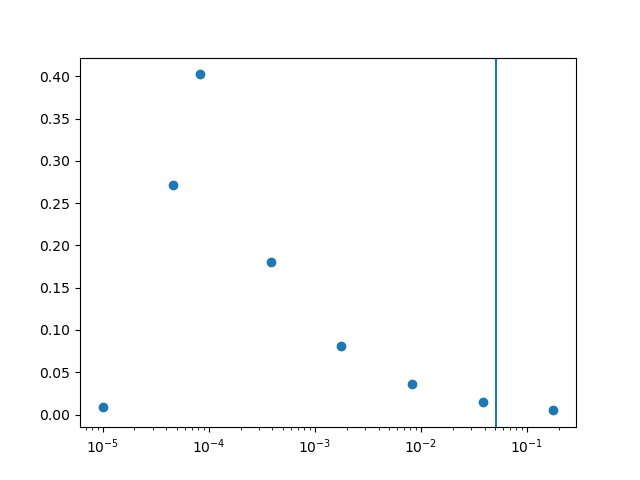

In [10]:
# pd.DataFrame({'Bin Limits'  :   np.append(vTotBins, 1e3),
#               'Probability' :   PTable[0],  
#                 'Total'     :   TotTable[0]             })

plotx = vTotBins + np.append(np.diff(vTotBins)[0:1], np.diff(vTotBins))
plotx = np.append(vTotBins[0], plotx)
figure()
plot(plotx, PTable[0], 'o')
# plot(PTable[0], 'o')
axvline(np.mean(TotTable[0]))
xscale('log')

# Now run transport using probability tables

In [11]:
ptables_list = [PTable, TotTable, CapTable, ScatTable, FisTable]
URR_Erange = np.array([20,149])*1e3
avg_URR_xs = rxn_means.flatten()
print(avg_URR_xs)
print(np.average(CapTable[0], weights = PTable[0]))

[0.00374754 0.00263581 0.00044184 0.0006699 ]
0.002062515112353865


In [88]:
#### problem 4
N = 1.5e2
G = 50
print(f'Particle Histories: {N}')
print(f'Generations: {G}')

Emin = 1e-5
Emax = 2e7 
iEbins = 200
rng = np.random.default_rng()

# tally_avg = tallies.tallies(Emin, Emax, iEbins)
tally_avg = functions_for_transport.transport_loop_0D_CE(N, G, tally_avg, mat_no_URR, rng, URR_Erange, None, avg_URR_xs)
k_avg, kvar_avg, flux_avg = tally_avg.final_analysis() 

# tally_ptables = tallies.tallies(Emin, Emax, iEbins)
tally_ptables = functions_for_transport.transport_loop_0D_CE(N, G, tally_ptables, mat_no_URR, rng, URR_Erange, ptables_list, None)
k_ptables, kvar_ptables, flux_ptables = tally_ptables.final_analysis() 

print(k_avg, kvar_avg)
print(k_ptables, kvar_ptables)

Particle Histories: 150.0
Generations: 50
0.6569491749174917 0.001405678369523064
1.358923408182098 0.0020725239849419875


In [95]:
# import SPiderFighTer
# print(k_avg, kvar_avg)
# print(k_ptables, kvar_ptables)

fluxes = np.load("/Users/noahwalton/Library/Mobile Documents/com~apple~CloudDocs/References/NE 697 Advanced Transport Methods/URR Project/fluxes.npy")
keffs = np.load("/Users/noahwalton/Library/Mobile Documents/com~apple~CloudDocs/References/NE 697 Advanced Transport Methods/URR Project/keffs.npy")

keff_histories = np.mean(keffs, axis=0)
flux_histories = np.mean(fluxes, axis=0)
np.shape(flux_histories)

(400,)

Text(0, 0.5, 'Flux per unit E')

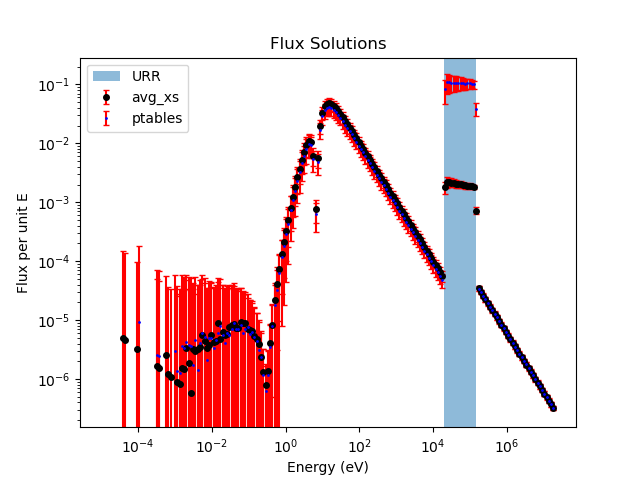

In [121]:
# %%
figure()
errorbar(tally_avg.Ebins, flux_avg[0], yerr=np.sqrt(flux_avg[1]), 
                                                            fmt='.', color='k', ms=8, ecolor='r', capsize=2,
                                                            label='avg_xs')

errorbar(tally_ptables.Ebins, flux_ptables[0], yerr=np.sqrt(flux_ptables[1]), 
                                                            fmt='.', color='b', ms=2, ecolor='r', capsize=2,
                                                            label='ptables')

# scatter(tally_ptables.Ebins, flux_histories[0:200], label='all hist', color='yellow', s=6, zorder=3)



axvspan(xmin=min(URR_Erange), xmax=max(URR_Erange), alpha=0.5, label='URR')

xscale('log')
yscale('log')
legend()
# xlim([945,900e3])
# ylim([1e-5,2e-1])
title('Flux Solutions')
xlabel('Energy (eV)')
ylabel('Flux per unit E')

Text(0, 0.5, 'Difference')

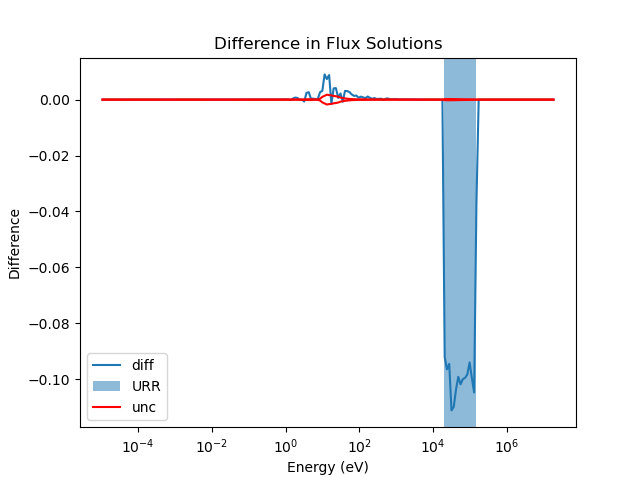

In [59]:
figure()
plot(tally_avg.Ebins, flux_avg[0]-flux_ptables[0], label='diff')
xscale('log')
axvspan(xmin=min(URR_Erange), xmax=max(URR_Erange), alpha=0.5, label='URR')

err_diff = np.sqrt( flux_avg[1]*(-flux_ptables[0])**2 + flux_ptables[1]*(flux_avg[0])**2 )
plot(tally_avg.Ebins, 0-err_diff, color='r')
plot(tally_avg.Ebins, 0+err_diff, color='r', label='unc')

xscale('log')
legend()
title('Difference in Flux Solutions')
xlabel('Energy (eV)')
ylabel('Difference')


### Use histories to calculate average 

In [85]:
flux = np.zeros_like(flux_ptables)
keff = np.zeros((1,2))
                   
for i in range(1000):
    file = f"/Users/noahwalton/Library/Mobile Documents/com~apple~CloudDocs/References/NE 697 Advanced Transport Methods/URR Project/histories/transport_result_{i}.csv"
    flux_dat = np.genfromtxt(file, delimiter=',', skip_header=1)
    if len(flux_dat) > 400:
        flux_dat = flux_dat[0:-1]
    k_unc_dat = np.loadtxt(file, delimiter=',', max_rows=1, usecols=(0,1))
    flux += np.reshape(flux_dat, (2,200))
    keff += k_unc_dat


In [86]:
i=100
file = f"/Users/noahwalton/Library/Mobile Documents/com~apple~CloudDocs/References/NE 697 Advanced Transport Methods/URR Project/histories/transport_result_{i}.csv"
# len(np.genfromtxt(file, delimiter=',', skip_header=1)[0:-1])
# print(np.shape(flux_ptables))
# np.shape(np.reshape(flux_dat, (2,200)))
keff/1000


array([[1.33792853, 0.01046749]])

#### Need to figure out the dyson mehta statistic for when to quit sampling resonances!

In [18]:
# # calculate D3 statistic

# Ef = E_levels[-1]
# Ei = E_levels[0]
# N = []
# Erange = np.linspace(Ei, Ef, 100)
# for El in Erange:
#     test = 0
#     N.append(np.count_nonzero(np.array(E_levels)[E_levels<El]))

# figure()
# plot(Erange,N)
# # xscale('log')

# def linear(vars):
#     return vars[0]*Erange+vars[1]
# def fit(vars):
#     return np.sum( (linear(vars) - np.array(N))**2/np.diff(Erange)[0])

# from scipy.optimize import minimize
# out = minimize(fit, x0=(1e3,0))

# print(out.fun/2/len(E_levels))
# print(1/np.pi**2 * np.log(len(E_levels)-0.06871) )

# plot(Erange, linear(out.x))
